#### TYPE	DESCRIPTION
#### PER	Named person or family.
#### LOC	Name of politically or geographically defined location (cities, provinces, countries, international regions, bodies of water, mountains).
#### ORG	Named corporate, governmental, or other organizational entity.
#### MISC	Miscellaneous entities, e.g. events, nationalities, products or works of art.

In [1]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

In [8]:
doc = nlp('European authorities fined Google a record $5.1 billion on Wednesday JAVA for abusing its power in the mobile phone market and ordered the company to alter its practices')
print([(X.text, X.label_) for X in doc.ents])

[('European', 'NORP'), ('Google', 'ORG'), ('$5.1 billion', 'MONEY'), ('Wednesday', 'DATE')]


In [12]:
# !python -m spacy download it_core_news_sm
import it_core_news_sm
nlp_ita = it_core_news_sm.load()

In [22]:
doc = nlp_ita('Io sono Giorgio. Io vivo a Napoli. Python è un linguaggio di programmazione. Java. ')
print([(X.text, X.label_) for X in doc.ents])

[('Giorgio', 'PER'), ('Napoli', 'LOC'), ('Python', 'MISC'), ('Java', 'MISC')]


In [43]:
for i,j in dict([(X.text, X.label_) for X in doc.ents]).items():
    if j!='MISC':
        print(i)

Giorgio
Napoli


In [55]:
text = nlp_ita('io so usare bene Java e Python. ho qualche esperienza con R e ho fatto progetti di machine learning')
print([(X.text, X.label_) for X in text.ents])

[('Java', 'MISC'), ('Python', 'MISC'), ('R', 'MISC')]


## Test on the vacancies

In [56]:
# !pip install -r requirements.txt
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib
import re
import nltk
import numpy as np
from IPython.display import Image
import pickle
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('words')

In [86]:
professioni = pd.read_csv('data/professioni.csv')
Conoscenze = professioni.Conoscenze.apply(lambda x: str(x).split('\n'))
Conoscenze.iloc[0]

['LDAP',
 'LINQ',
 'MDX',
 'N1QL',
 'SPARQL',
 'XQuery',
 'business intelligence',
 'dati non strutturati',
 'valutazione della qualità dei dati']

In [98]:
text = nlp_ita(' '.join(Conoscenze.iloc[0]))
print([(X.text, X.label_) for X in text.ents])

[('SPARQL', 'MISC')]


In [101]:
subgroup = professioni.Subgroup.apply(lambda x: x.split('\n'))
subgroup.iloc[0]

['Attuario',
 'Data scientist',
 'Esperto in ricerca operativa',
 'Esperto ricerca operativa',
 'Statistici',
 'Statistico',
 'Statistico applicato',
 'Statistico economico',
 'Statistico esperto in controlli di qualità',
 'Statistico metodologico',
 '']

In [102]:
text = nlp_ita(' '.join(subgroup.iloc[0]))
print([(X.text, X.label_) for X in text.ents])

[('Data scientist Esperto', 'ORG'), ('Esperto', 'LOC'), ('Statistici Statistico Statistico', 'ORG'), ('Statistico economico Statistico', 'LOC'), ('Statistico', 'LOC')]


#### Does not work properly. Let's try something else

#### LSTM

In [244]:
df = pd.read_csv('complaints.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1569033 entries, 0 to 1569032
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype 
---  ------                        --------------    ----- 
 0   Date received                 1569033 non-null  object
 1   Product                       1569033 non-null  object
 2   Sub-product                   1333868 non-null  object
 3   Issue                         1569033 non-null  object
 4   Sub-issue                     1003427 non-null  object
 5   Consumer complaint narrative  519091 non-null   object
 6   Company public response       595093 non-null   object
 7   Company                       1569033 non-null  object
 8   State                         1542425 non-null  object
 9   ZIP code                      1420210 non-null  object
 10  Tags                          214450 non-null   object
 11  Consumer consent provided?    936554 non-null   object
 12  Submitted via                 1569033 non-

In [245]:
df.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    378351
Mortgage                                                                        300011
Debt collection                                                                 289766
Credit reporting                                                                140432
Credit card                                                                      89190
Bank account or service                                                          86206
Credit card or prepaid card                                                      73734
Checking or savings account                                                      61653
Student loan                                                                     57562
Consumer Loan                                                                    31604
Vehicle loan or lease                                                            16693
Money transfer, virtual currency, or money 

In [246]:
df.loc[df['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df.loc[df['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
df.loc[df['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df.loc[df['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
df = df[df.Product != 'Other financial service']
df.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    518783
Mortgage                                                                        300011
Debt collection                                                                 289766
Credit card or prepaid card                                                     162924
Bank account or service                                                          86206
Checking or savings account                                                      61653
Student loan                                                                     57562
Consumer Loan                                                                    31604
Payday loan, title loan, or personal loan                                        18375
Vehicle loan or lease                                                            16693
Money transfer, virtual currency, or money service                               15224
Money transfers                            

In [183]:
def print_plot(index):
    example = df[df.index == index][['Consumer complaint narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [189]:
print_plot(100)

My original lender was XXXX XXXX XXXX ; this loan was considered a private loan that my parents took out to pay for my college education. XXXX XXXX XXXX had switched servicers to XXXX XXXX. The original promissory note I have, shows my father as applicant # 1/borrower, my mother as applicant # 2/co-borrower, and myself as student. This loan originated in XX/XX/XXXX. My father and I share the same name and I feel that has added confusion. My father always made the payments on this loan, as well as, collected tax documents and deductions on this loan, as the borrower. In XX/XX/XXXX, my father passed away from XXXX. My mother contacted XXXX and she was told about loan forgiveness. She submitted my fathers death certificate and she waited 32 days for an answer. Unfortunately, they did not approve the loan for forgiveness. Instead, XXXX has switched me, from student, to borrower and my mother stays as co-borrower. How did I go from being a student on a promissory note, to now the sole borro

In [247]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = str(text).lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    text = text.replace('#','')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(clean_text)
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].str.replace('\d+', '')

In [194]:
print_plot(100)

original lender loan considered private loan parents took pay college education switched servicers original promissory note shows father applicant borrower mother applicant coborrower student loan originated father share name feel added confusion father always made payments loan well collected ta documents deductions loan borrower father passed away mother contacted told loan forgiveness submitted fathers death certificate waited days answer unfortunately approve loan forgiveness instead switched student borrower mother stays coborrower go student promissory note sole borrower called unsuccessful requested documents including denial letter stating loan wasnt forgiven result father death promissory note file well loan terms indicating legally responsible loan success retrieving documents told entitled documents contact promissory note told representative promissory note file legible couldnt confirm supposed borrower coborrower contacted copy promissory note email told promissory note re

##### LSTM Modeling
Vectorize consumer complaints text, by turning each text into either a sequence of integers or into a vector.
Limit the data set to the top 5,0000 words.
Set the max number of words in each complaint at 250.

In [248]:
### EXAMPLE
samples = ['The cat say on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(samples)

one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(word_index)

Found 9 unique tokens.
{'the': 1, 'cat': 2, 'say': 3, 'on': 4, 'mat': 5, 'dog': 6, 'ate': 7, 'my': 8, 'homework': 9}


#### It should be the same as count.vectorizer in sklearn

In [249]:
from tensorflow.keras.preprocessing.text import Tokenizer
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 170627 unique tokens.


In [250]:
word_index

{'nan': 1,
 'credit': 2,
 'account': 3,
 'report': 4,
 'information': 5,
 'would': 6,
 'payment': 7,
 'loan': 8,
 'debt': 9,
 'bank': 10,
 'told': 11,
 'received': 12,
 'company': 13,
 'card': 14,
 'time': 15,
 'called': 16,
 'never': 17,
 'reporting': 18,
 'payments': 19,
 'sent': 20,
 'letter': 21,
 'back': 22,
 'also': 23,
 'pay': 24,
 'get': 25,
 'paid': 26,
 'mortgage': 27,
 'call': 28,
 'said': 29,
 'amount': 30,
 'made': 31,
 'one': 32,
 'due': 33,
 'number': 34,
 'accounts': 35,
 'could': 36,
 'phone': 37,
 'days': 38,
 'money': 39,
 'balance': 40,
 'collection': 41,
 'late': 42,
 'asked': 43,
 'still': 44,
 'consumer': 45,
 'since': 46,
 'nt': 47,
 'date': 48,
 'even': 49,
 'please': 50,
 'years': 51,
 'dispute': 52,
 'name': 53,
 'make': 54,
 'home': 55,
 'file': 56,
 'contacted': 57,
 'request': 58,
 'us': 59,
 'check': 60,
 'interest': 61,
 'month': 62,
 'service': 63,
 'months': 64,
 'removed': 65,
 'new': 66,
 'help': 67,
 'times': 68,
 'complaint': 69,
 'address': 70,
 '

#### Truncate and pad the input sequences so that they are all in the same length for modeling.

In [251]:
import tensorflow.keras 
X = tokenizer.texts_to_sequences(df['Consumer complaint narrative'].values)
X = tensorflow.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1567974, 250)


In [255]:
X

array([[   0,    0,    0, ...,  268,  207,  240],
       [   0,    0,    0, ...,    0,    0,    1],
       [   0,    0,    0, ...,    2,   18,  175],
       ...,
       [   0,    0,    0, ...,    7, 5104, 1327],
       [   0,    0,    0, ...,    8, 2031, 1764],
       [   0,    0,    0, ...,   50,   67,   59]], dtype=int32)

### Converting categorical labels to numbers.

In [256]:
Y = pd.get_dummies(df['Product']).values
print('Shape of label tensor:', Y.shape)
Y

Shape of label tensor: (1567974, 13)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [257]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1411176, 250) (1411176, 13)
(156798, 250) (156798, 13)


The first layer is the embedded layer that uses 100 length vectors to represent each word.

SpatialDropout1D performs variational dropout in NLP models.

The next layer is the LSTM layer with 100 memory units.

The output layer must create 13 output values, one for each class.

Activation function is softmax for multi-class classification.

Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(13, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

/opt/anaconda3/envs/giorgio/lib/python3.8/site-packages/tensorflow/python/ops/gradients_impl.py:111: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Train on 1270058 samples, validate on 141118 samples
Epoch 1/5
 199232/1270058 [===>..........................] - ETA: 2:03:26 - loss: 1.7062 - acc: 0.4003

In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

#### LSTM on Job Vacancies

In [2]:
import pandas as pd
import numpy as np
dati_aprile = pd.read_csv('Job_vacancies_aprile_completo.csv', skiprows=1, usecols = [1,2,3],\
                          names = ['Target','Sub_Role','Job_Description'])
dati_aprile = dati_aprile.reindex(np.random.permutation(dati_aprile.index))
dati_aprile.drop('Sub_Role',axis = 1, inplace = True)
print('dati_aprile shape {}'.format(dati_aprile.shape))
dati_aprile[['Target','Job_Description']].head()

dati_aprile shape (650, 2)


,Target,Job_Description
309,Tecnici web,"Novamont S.p.A, azienda leader nella produzion..."
474,Camerieri di ristorante,"Idea Lavoro SpA, sta selezionando per Ristoran..."
219,Statistici,All'interno del team di Advanced Analytics per...
256,Statistici,La persona prescelta elaborerà grandi quantità...
499,Camerieri di ristorante,Manpower S.r.l. ricerca per importante azienda...


In [6]:
import re
import nltk
from nltk import word_tokenize
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
Fonti = ['randstad', 'monster', 'infojob', 'technical', 'kelly', 'services', 'italia', 'lavoropi',\
             'quanta','adeccp','spa','vimercate','temporary','openjobmetis','agenzia']

noisy_words = ['degli','tipi','del','dei','delle','per','nel','dell',\
               'sui','less','sul','che','jsss','teor','dal','della', 'degl','alla', \
              'nell','sull']
stemmer = nltk.stem.snowball.ItalianStemmer(ignore_stopwords=False)


def clean_data(text):
    text = text.lower().replace('\n','')
    text = text.replace("'"," ")
    text = text.replace('/'," ")
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub(' ', text)
    text = [i for i in word_tokenize(text) if len(i) > 2 and i not in Fonti and i not in noisy_words]
    text = ' '.join([stemmer.stem(i) for i in text])
    return text

dati_aprile['Job_Description'] = dati_aprile['Job_Description'].apply(clean_data)


In [7]:
dati_aprile['Job_Description'].iloc[1]

'ide lavor sta selezion ristor american bar rom centr commis camer salacon seguent caratterist esperit ruol press bar ristorantedisponibilit immed lavor orar seral dall luned domen con giorn ripos offre contratt somministr temp determin ccnl turism pubblic eserciz confcommerc con possibilit prorog inser orar lavor sar prevalent nell fasc seral dall alle candid possess requis poss invi lor candidatur con line mail filial mil idealavor riport oggett rifer commis camer sal'

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 700
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(dati_aprile['Job_Description'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 5397 unique tokens.


In [23]:
word_index

{'lavor': 1,
 'con': 2,
 'esperit': 3,
 'conosct': 4,
 'nell': 5,
 'dat': 6,
 'client': 7,
 'capacit': 8,
 'candid': 9,
 'ricerc': 10,
 'risors': 11,
 'contratt': 12,
 'tecnic': 13,
 'inser': 14,
 'temp': 15,
 'vend': 16,
 'una': 17,
 'disponibilit': 18,
 'azi': 19,
 'settor': 20,
 'requis': 21,
 'all': 22,
 'buon': 23,
 'gestion': 24,
 'attivit': 25,
 'web': 26,
 'tim': 27,
 'orar': 28,
 'ottim': 29,
 'richiest': 30,
 'svilupp': 31,
 'occuper': 32,
 'serviz': 33,
 'team': 34,
 'elettr': 35,
 'part': 36,
 'manutenzion': 37,
 'diplom': 38,
 'lingu': 39,
 'pregress': 40,
 'ingles': 41,
 'profil': 42,
 'seguent': 43,
 'full': 44,
 'analis': 45,
 'statist': 46,
 'turn': 47,
 'progett': 48,
 'addett': 49,
 'livell': 50,
 'oper': 51,
 'compett': 52,
 'prodott': 53,
 'informat': 54,
 'ideal': 55,
 'ruol': 56,
 'anni': 57,
 'mansion': 58,
 'utilizz': 59,
 'ristor': 60,
 'impiant': 61,
 'richied': 62,
 'matur': 63,
 'ambit': 64,
 'offre': 65,
 'com': 66,
 'prepar': 67,
 'meccan': 68,
 'determin

In [24]:
import tensorflow.keras 
X = tokenizer.texts_to_sequences(dati_aprile['Job_Description'].values)
X = tensorflow.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (650, 700)


In [26]:
dati_aprile['Job_Description'].iloc[0]

'novamont azi leader nell produzion mater plastic biodegrad font rinnov ricerc una tirocin ambit funzion comun istituzional centr stud qualit communication content junior risors sar affianc dall tutor nell attivit comun digital particol predisporr post canal social aziendal twitter linkedin facebook instagram monitoragg convers content curation ricerc individu conten interess societ aggiorn sezion dinam sit corpor con elabor test news sezion event aziendal dissemin progett ricerc particol aggiorn period pian comun dissemin progett ricerc societ support predisposizion verif strument comun progett sit web leaflet poster script vide predisposizion material utilizz gli event progett requis laure second livell titol equivalent uno nei seguent ambit disciplinar scienz comun econom marketing ottim conosct lingu ingles parl scritt complet profil spicc dot organizz curiosit capacit relazion lavor team flessibilit gestion dell stress sed novar'

In [25]:
print(len(X[0]))
print(len(dati_aprile['Job_Description'].iloc[0]))
X[0]

700
946


array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [142]:
Y = pd.get_dummies(dati_aprile['Target']).values
print('Shape of label tensor:', Y.shape)
Y

Shape of label tensor: (650, 6)


array([[0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0]], dtype=uint8)

In [143]:
dati_aprile['Target'].head()

284                          Statistici
515    Commessi delle vendite al minuto
636    Commessi delle vendite al minuto
434             Camerieri di ristorante
604    Commessi delle vendite al minuto
Name: Target, dtype: object

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

NameError: name 'train_test_split' is not defined

In [29]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(80, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 50
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 700, 100)          1000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 700, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 80)                57920     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 486       
Total params: 1,058,406
Trainable params: 1,058,406
Non-trainable params: 0
_________________________________________________________________


NameError: name 'X_train' is not defined

In [134]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

130/130 [==============================] - 0s 1ms/step
Test set
  Loss: 0.511
  Accuracy: 0.831


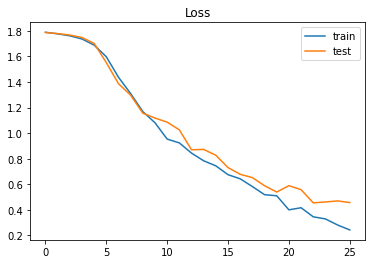

In [135]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [127]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 100, 100)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 40)                22560     
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 246       
Total params: 1,022,806
Trainable params: 1,022,806
Non-trainable params: 0
_________________________________________________________________


In [124]:
dir(model)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_inbound_node',
 '_add_unique_metric_name',
 '_add_variable_with_custom_getter',
 '_assert_input_compatibility',
 '_base_init',
 '_build_input_shape',
 '_cache_output_metric_attributes',
 '_call_and_compute_mask',
 '_call_convention',
 '_check_trainable_weights_consistency',
 '_checkpoint_dependencies',
 '_checkpointable_saver',
 '_collected_trainable_weights',
 '_compute_output_and_mask_jointly',
 '_compute_previous_mask',
 '_dataset_iterator_cache',
 '_deferred_dependencies',
 '_determine_call_convention',
 '_distribution_standardize_user_data',
 '_distribution_strategy',
 '_d